# Reinforcement Learning for optimization

In [217]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm.auto import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this notebook, we will show how to build and resolve the **Knapsack** problem using **Reinforcement Learning**. 

##### Knapsack Problem 
$$ max \sum_{i=1}^N p_i x_i$$
$$\sum_{i=1}^N w_i x_i <=  W $$

In [4]:
N = 10  # Considering 10 items 
W = 200 # Total capacity 
p = np.array([100,180,109,200,550,300,305,390,105,207]) # Item prices
w = np.array([20,20,39,45,120,58,70,84,30,40]) # Item weights 

# Problem definition
## Defining the environment

In [270]:
class KnapsackEnvironment:
    def __init__(self,weights,values,max_capacity):
        
        # Store default parameters
        self.weights = weights
        self.values = values
        self.max_capacity = max_capacity

        assert len(self.weights) == len(self.values)
        self.n_items = len(self.weights)
        
        # Configuration for RL agent
        self.action_space = self.n_items
        self.observation_space = self.n_items
        
        # Reset for initialization
        self.reset()
        
    def __repr__(self):
        
        weight = self.compute_total_weight()
        value = self.compute_total_value()
        n_items = np.sum(self.state)
        state_str = self.state_to_str()
        state_index = self.state_to_index()
        return f"Knapsack({state_str},items={n_items}/{self.n_items},value={value},weight={weight}/{self.max_capacity},state={state_index})"
    

    def compute_total_weight(self):
        return np.sum(self.weights * self.state)

    def compute_total_value(self):
        return np.sum(self.values * self.state)
    
    def compute_reward(self):
        value = self.compute_total_value()
        weight = self.compute_total_weight()
        
        if weight > self.max_capacity:
            return - np.sum(self.values)
        else:
            return value
        
    def reset(self):
        state = np.zeros(self.n_items)
        self.state = state
        state_index = self.state_to_index()
        return state_index
    
    def step(self,i):
        # Action of putting item i in the knapsack

        # Adding item i
        self.state[i] = 1
        
        # Computing and returning the reward
        reward = self.compute_reward()
        
        # Returns also new state and if the experience is finished
        s_next = self.state_to_index()
        done = reward < 0 or np.sum(self.state) == self.n_items
        
        return s_next,reward,done
    
    def state_to_str(self):
        return "".join(map(str,env.state.astype(int)))
        
    
    def state_to_index(self):
        # Use binary representation to encode state
        state_str = self.state_to_str()
        return int(state_str,2)
        
        
env = KnapsackEnvironment(w,p,W)
env

Knapsack(0000000000,items=0.0/10,value=0.0,weight=0.0/200,state=0)

In [271]:
env.reset()

0

In [288]:
s_next,reward,done = env.step(4)
print(env)
print(s_next,reward,done)

Knapsack(1100111010,items=6.0/10,value=1540.0,weight=318.0/200,state=826)
826 -2446 True


## How many possible states

Using the nCr (n choose r function) $\binom{r}{n}$

In [81]:
import scipy.special

# Using the nCr (n choose r function)
scipy.special.comb(10,10)

1.0

In [82]:
n_items = 10

def compute_n_states(n_items):
    return np.sum([scipy.special.comb(n_items,i) for i in range(n_items+1)])

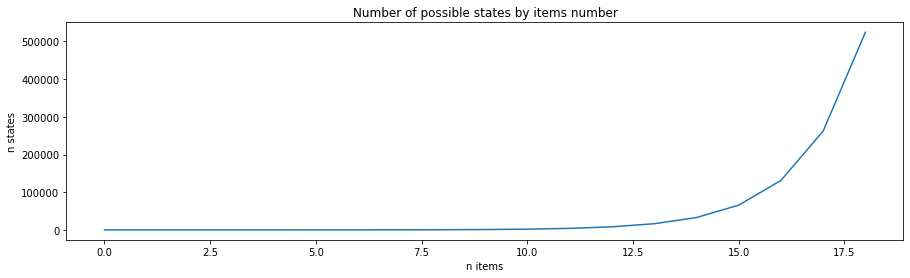

In [83]:
n_states = []
for n_items in x:
    n_states.append(compute_n_states(n_items))
    
pd.Series(n_states).plot(
    figsize = (15,4),
    logy = False,
    title = "Number of possible states by items number",
    xlabel = "n items",
    ylabel = "n states"
)
plt.show()

## Defining the agent

In [213]:
class QAgent:
    def __init__(self,n_items,epsilon = 1.0,epsilon_min = 0.01,epsilon_decay = 0.999,gamma = 0.95,lr = 0.8):
        self.states_size = int(compute_n_states(n_items))
        self.actions_size = n_items
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.lr = lr
        self.Q = self.build_model(self.states_size,self.actions_size)
        self.reset_memory()
        
    def expand_state_vector(self,state):
        if len(state.shape) == 1 or len(state.shape)==3:
            return np.expand_dims(state,axis = 0)
        else:
            return state

    def remember(self,*args):
        self.memory.save(args)

    def build_model(self,states_size,actions_size):
        Q = np.zeros([states_size,actions_size])
        return Q


    def train(self,s,a,r,s_next):
        self.Q[s,a] = self.Q[s,a] + self.lr * (r + self.gamma*np.max(self.Q[s_next,a]) - self.Q[s,a])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def act(self,s):

        # Get Q Vector
        q = np.copy(self.Q[s,:])

        # Action masking to avoid adding the same items over and over 
        q[self.actions_memory] = -np.inf

        if np.random.rand() > self.epsilon:
            a = np.argmax(q)
        else:
            legal_actions = np.where(q >= 0)[0]
            if len(legal_actions) == 0:
                return np.random.randint(self.actions_size)
            else:
                a = np.random.choice(legal_actions)
            
        self.remember_action(a)

        return a
    
    def remember_action(self,a):
        self.actions_memory.append(a)

    def reset_memory(self):
        self.actions_memory = []


In [214]:
agent = QAgent(10)

In [205]:
agent.Q.shape

(1024, 10)

In [184]:
agent.act(0)

5

## Defining the training loop

In [323]:
def run_episode(env,agent,verbose = 1):

    s = env.reset()
    agent.reset_memory()

    max_step = env.n_items
    
    episode_best_reward = 0
    episode_best_strategy = None
    
    i = 0
    while i < max_step:

        # Choose an action
        a = agent.act(s)
        
        # Take the action, and get the reward from environment
        s_next,r,done = env.step(a)

        if not done:
            episode_best_reward = r
            episode_best_strategy = np.binary_repr(s_next)
            
        if verbose: print(env,s_next,r,done)
        
        # Update our knowledge in the Q-table
        agent.train(s,a,r,s_next)
        
        # Update the caches
        s = s_next
        
        # If the episode is terminated
        i += 1
        
        if done:
            break

    return env,agent,episode_best_reward,episode_best_strategy





def run_n_episodes(env,agent,n_episodes):

    # Store the rewards
    rewards = []

    # Experience replay
    for i in tqdm(range(n_episodes)):

        # Run the episode
        env,agent,reward,strategy = run_episode(env,agent,verbose = 0)
        rewards.append({
            "reward":reward,
            "strategy":strategy,
        })
        
    rewards = pd.DataFrame(rewards)

    # Show rewards
    plt.figure(figsize = (15,3))
    plt.title("Rewards over training")
    plt.plot(rewards["reward"])#, 'o',markersize = 1)
    plt.show()

    return rewards,env,agent

## Training

In [324]:
agent = QAgent(10)

run_episode(env,agent,verbose = True)

Knapsack(0000000100,items=1.0/10,value=390.0,weight=84.0/200,state=4) 4 390.0 False
Knapsack(1000000100,items=2.0/10,value=490.0,weight=104.0/200,state=516) 516 490.0 False
Knapsack(1010000100,items=3.0/10,value=599.0,weight=143.0/200,state=644) 644 599.0 False
Knapsack(1010010100,items=4.0/10,value=899.0,weight=201.0/200,state=660) 660 -2446 True


(Knapsack(1010010100,items=4.0/10,value=899.0,weight=201.0/200,state=660),
 599.0,
 '1010000100')

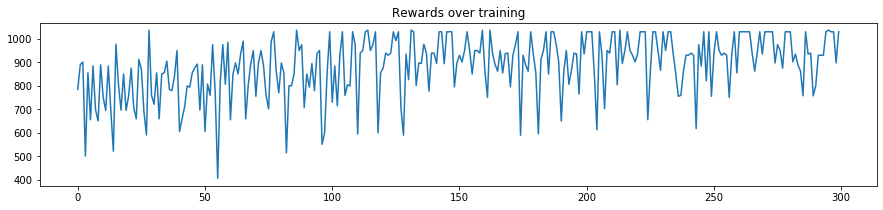

,reward,strategy
295,1037.0,1100100001
296,1030.0,100110000
297,1030.0,100110000
298,897.0,10101
299,1030.0,100110000


In [334]:
W = 200 # Total capacity 
p = np.array([100,180,109,200,550,300,305,390,105,207]) # Item prices
w = np.array([20,20,39,45,120,58,70,84,30,40]) # Item weights 

env = KnapsackEnvironment(w,p,W)
agent = QAgent(len(w),epsilon = 1,epsilon_decay=0.999,gamma = 0.99,lr = 0.1)


rewards,env,agent = run_n_episodes(env,agent,300)
rewards.tail()

## Adaptive decision making

In [295]:

s = env.reset()
agent.reset_memory()

# Choose an action
a = agent.act(s)

# Take the action, and get the reward from environment
s_next,r,done = env.step(a)

# Exercise 
- Random weights & values
- Multi Knapsack problem
- Deep Reinforcement Learning

# References
- https://emergence.pub/blog/2021/03/06/tsp
- https://towardsdatascience.com/neural-knapsack-8edd737bdc15